# Матрица будущих фьючерсных котировок для работы с Commitments of Traders

Алгоритм предназначен для обработки биржевых котировок фьючерсов с сайта Finance Yahoo. После загрузки из источника котировки адаптируются под список дат (публикации Commitments of Traders), и транспонируются со сдвигом в матрицу будущих цен. На основе матриц рассчитываются агрегированные показатели.

# Расчеты

In [179]:
!pip install yfinance

https://pypi.org/project/yfinance/ 

In [180]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import copy

In [181]:
class Download_Stock_Prices(object):

# Матрицы рассчитываются на основе номеров столбцов расчетного датасета

    def __init__(self, ticker, yf_ticker, number_future_weeks, target_price_count, skip_count_less):
        self.ticker = ticker
        self.yf_ticker = yf_ticker
        self.number_future_weeks = number_future_weeks
        self.target_price_count = target_price_count
        self.skip_count_less = skip_count_less

        self.name = ticker
        self.descrip = str(number_future_weeks) + ' / ' + str(round(target_price_count*100,1)) + '%' + ' / ' + str(skip_count_less)

        # Файл с датировкой отчетов СОТ
        dates_url = 'https://raw.githubusercontent.com/ForestTiger-GH/COTRA/main/Даты%20отчетов%20СОТ.txt'
        dates = pd.read_csv('https://raw.githubusercontent.com/ForestTiger-GH/COTRA/main/COTR_Dates.txt', parse_dates=True)
        dates['Date'] = pd.to_datetime(dates['Date'])
        self.dates = dates['Date']

        # Загрузка с Yahoo и подготовка
        self.ticker = yf.Ticker(yf_ticker).history(period="max")
        self.ticker.index.name = 'Index'
        self.ticker['Date'] = self.ticker.index
        XXX = self.ticker.append(dates)
        self.ticker = XXX.sort_values(by=['Date', 'Close'], ascending=True).ffill().drop_duplicates(subset=['Date']).merge(dates['Date'], how='right')
        self.ticker.drop('Dividends', axis=1, inplace=True)
        self.ticker.drop('Stock Splits', axis=1, inplace=True)

        # Переменные названия столбцов
        column_week_prefix = "Week_"
        column_bilweek_prefix = "Bin_Long_Week_"
        column_bisweek_prefix = "Bin_Short_Week_"
        column_binweek_prefix = "Bin_Neut_Week_"

        # matrix: CLOSE real
        for i in range(number_future_weeks):
            self.ticker[str(column_week_prefix + '%03d' % (i+1))] = ((self.ticker['Close'].shift(-i-1)) / self.ticker['Close'] - 1)

        # matrix: CLOSE long binary
        for i in range(number_future_weeks):
            self.ticker[str(column_bilweek_prefix + '%03d' % (i+1))] = ((self.ticker['Close'].shift(-i-1)) / self.ticker['Close'] - 1)

            self.ticker.loc[self.ticker[str(column_bilweek_prefix + '%03d' % (i+1))] >= target_price_count, str(column_bilweek_prefix + '%03d' % (i+1))] = 1
            self.ticker.loc[self.ticker[str(column_bilweek_prefix + '%03d' % (i+1))] < target_price_count, str(column_bilweek_prefix + '%03d' % (i+1))] = 0

        # matrix: CLOSE short binary
        for i in range(number_future_weeks):
            self.ticker[str(column_bisweek_prefix + '%03d' % (i+1))] = ((self.ticker['Close'].shift(-i-1)) / self.ticker['Close'] - 1)

            self.ticker.loc[self.ticker[str(column_bisweek_prefix + '%03d' % (i+1))]*(-1) <= target_price_count, str(column_bisweek_prefix + '%03d' % (i+1))] = 0
            self.ticker.loc[self.ticker[str(column_bisweek_prefix + '%03d' % (i+1))]*(-1) > target_price_count, str(column_bisweek_prefix + '%03d' % (i+1))] = 1

    def price_tape(self):
        return self.ticker.iloc[:, :6]

    def close_price(self):
        return self.ticker['Close']

    def fmx_real(self):
        matrix_real = self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, self.number_future_weeks*2 : self.number_future_weeks*3]
        return matrix_real

    def fmx_bilong(self):
        matrix_bilong = self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, : self.number_future_weeks]
        return matrix_bilong

    def fmx_bishort(self):
        matrix_bishort = self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, self.number_future_weeks : self.number_future_weeks*2]
        return matrix_bishort

    def fmx_sum_bilong(self):
        return self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, : self.number_future_weeks].sum(axis=1)

    def fmx_sum_bishort(self):
        return self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, self.number_future_weeks : self.number_future_weeks*2].sum(axis=1)

    def fmx_sum_binet(self):
        return self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, : self.number_future_weeks].sum(axis=1) - self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, self.number_future_weeks : self.number_future_weeks*2].sum(axis=1)

    def fmx_sum_bil_skip(self):
        sum_bilong = self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, : self.number_future_weeks].sum(axis=1)
        sum_bilong = sum_bilong.where(sum_bilong >= self.skip_count_less, 0)
        return pd.DataFrame(sum_bilong, columns=['Longs amount sum'])

    def fmx_sum_bis_skip(self):
        sum_bishort = self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, self.number_future_weeks : self.number_future_weeks*2].sum(axis=1)
        sum_bishort = sum_bishort.where(sum_bishort >= self.skip_count_less, 0)
        return pd.DataFrame(sum_bishort, columns=['Shorts amount sum'])

    def fmx_sum_bin_skip(self):
        sum_binet = self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, : self.number_future_weeks].sum(axis=1) - self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, self.number_future_weeks : self.number_future_weeks*2].sum(axis=1)
        sum_binet = sum_binet.where(abs(sum_binet) >= self.skip_count_less, 0)
        return pd.DataFrame(sum_binet, columns=['Nets amount sum'])

    def fmx_sum_bilbisbin_skip(self):
        sum_bilong = self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, : self.number_future_weeks].sum(axis=1)
        sum_bilong = sum_bilong.where(sum_bilong >= self.skip_count_less, 0)
        sum_bishort = self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, self.number_future_weeks : self.number_future_weeks*2].sum(axis=1)
        sum_bishort = sum_bishort.where(sum_bishort >= self.skip_count_less, 0)
        sum_binet = self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, : self.number_future_weeks].sum(axis=1) - self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, self.number_future_weeks : self.number_future_weeks*2].sum(axis=1)
        sum_binet = sum_binet.where(abs(sum_binet) >= self.skip_count_less, 0)
        return pd.concat([pd.DataFrame(self.dates, columns=['Date']), pd.DataFrame(sum_bilong, columns=['Longs amount sum']), pd.DataFrame(sum_bishort, columns=['Shorts amount sum']), pd.DataFrame(sum_binet, columns=['Nets amount sum'])], axis=1)

# Ввод параметров

Download_Stock_Prices (ticker, yf_ticker, number_future_weeks, target_price_count, skip_count_less)

*   ticker  - пользовательское название финансового инструмента
*   yf_ticker - биржевой код финансового инструмента
*   number_future_weeks - количество будущих недель для построения матрицы (ширина)
*   target_price_count - целевая цена, значения выше которой будут учитываться
*   skip_count_less - отсечение собранного количества целевых цен, если их меньше


In [182]:
prices = Download_Stock_Prices('Coffee', 'KC=F', 26, 0.12, 5)

**Commodities**

*   Wheat_SRW = 'ZW=F'
*   Soybeans = 'ZS=F' 
*   Coffee = 'KC=F'

**Financial**

*   Canadian_Dollar = '6C=F'
*   British_Pound = '6B=F'
*   Russian_Ruble = '6R=F'


# Графический вывод

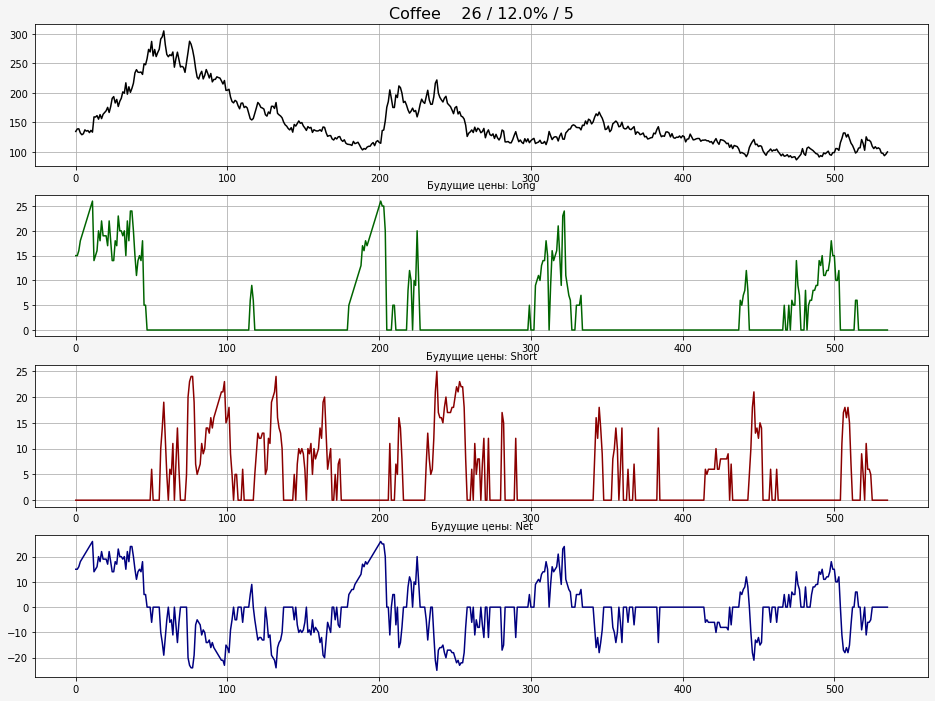

In [183]:
fig = plt.figure()
ax_1 = fig.add_subplot(4, 1, 1)
ax_1.grid()
ax_2 = fig.add_subplot(4, 1, 2)
ax_2.grid()
ax_3 = fig.add_subplot(4, 1, 3)
ax_3.grid()
ax_4 = fig.add_subplot(4, 1, 4)
ax_4.grid()
fig.set(facecolor = 'whitesmoke')

ax_1.set_title(prices.name+'    '+prices.descrip, fontsize = 16)
ax_1.plot(prices.close_price(), color='black')
ax_2.set_title('Будущие цены: Long', fontsize = 10)
ax_2.plot(prices.fmx_sum_bil_skip(), color='darkgreen')
ax_3.set_title('Будущие цены: Short', fontsize = 10)
ax_3.plot(prices.fmx_sum_bis_skip(), color='darkred')
ax_4.set_title('Будущие цены: Net', fontsize = 10)
ax_4.plot(prices.fmx_sum_bin_skip(), color='navy')

fig.set_figwidth(16)
fig.set_figheight(12)
fig.show()

# Вывод статистики

In [184]:
result = prices.fmx_sum_bilbisbin_skip()

In [185]:
result.to_csv(index=False)

'Date,Longs amount sum,Shorts amount sum,Nets amount sum\n2010-03-23,15.0,0.0,15.0\n2010-03-30,15.0,0.0,15.0\n2010-04-06,16.0,0.0,16.0\n2010-04-13,18.0,0.0,18.0\n2010-04-20,19.0,0.0,19.0\n2010-04-27,20.0,0.0,20.0\n2010-05-04,21.0,0.0,21.0\n2010-05-11,22.0,0.0,22.0\n2010-05-18,23.0,0.0,23.0\n2010-05-25,24.0,0.0,24.0\n2010-06-01,25.0,0.0,25.0\n2010-06-08,26.0,0.0,26.0\n2010-06-15,14.0,0.0,14.0\n2010-06-22,15.0,0.0,15.0\n2010-06-29,16.0,0.0,16.0\n2010-07-06,20.0,0.0,20.0\n2010-07-13,18.0,0.0,18.0\n2010-07-20,22.0,0.0,22.0\n2010-07-27,19.0,0.0,19.0\n2010-08-03,19.0,0.0,19.0\n2010-08-10,19.0,0.0,19.0\n2010-08-17,17.0,0.0,17.0\n2010-08-24,22.0,0.0,22.0\n2010-08-31,18.0,0.0,18.0\n2010-09-07,14.0,0.0,14.0\n2010-09-14,14.0,0.0,14.0\n2010-09-21,18.0,0.0,18.0\n2010-09-28,17.0,0.0,17.0\n2010-10-05,23.0,0.0,23.0\n2010-10-12,20.0,0.0,20.0\n2010-10-19,20.0,0.0,20.0\n2010-10-26,19.0,0.0,19.0\n2010-11-02,20.0,0.0,20.0\n2010-11-09,15.0,0.0,15.0\n2010-11-16,22.0,0.0,22.0\n2010-11-23,18.0,0.0,18.0\n2010-1